# Fit a cardinal Bayesian model

author: steeve laquitaine

Fit the cardinal Bayesian model to model circular estimate data and use the model generate predictions.

## Setup

In [3]:
# go to the project's root path
import os
os.chdir("..")

In [33]:
# import dependencies
from bsfit.nodes.models.bayes import CardinalBayes
from bsfit.nodes.dataEng import (
    simulate_dataset,
)
from bsfit.nodes.models.utils import (
    get_data, get_data_stats, get_prediction_stats
)
from bsfit.nodes.viz.prediction import plot_mean
from matplotlib import pyplot as plt
from bsfit.nodes.cirpy.viz import plot_von_mises, plot_von_mises_mixture
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set parameters

In [7]:
# set the parameters
SUBJECT = "sub01"
PRIOR_SHAPE = "vonMisesPrior"
PRIOR_MODE = 225
OBJ_FUN = "maxLLH"
READOUT = "map"
PRIOR_NOISE = [80, 40] # e.g., prior's std
STIM_NOISE = [0.33, 0.66, 1.0]
INIT_P = {
    "k_llh": [2.7, 10.7, 33],
    "k_prior": [2.7, 33],
    "k_card": [2000],
    "prior_tail": [0],
    "p_rand": [0],
    "k_m": [2000],
}
CENTERING = True

## Simulate dataset

In [8]:
# simulate a training dataset
train_dataset = simulate_dataset(
    stim_noise=STIM_NOISE,
    prior_mode=PRIOR_MODE,
    prior_noise=PRIOR_NOISE,
    prior_shape=PRIOR_SHAPE,
)

# use the train dataset as test to show 
# best predictions
test_dataset = get_data(train_dataset)

## Train model and predict

In [18]:
# instantiate the model
model = CardinalBayes(
    initial_params=INIT_P,
    prior_shape=PRIOR_SHAPE, 
    prior_mode=PRIOR_MODE, 
    readout=READOUT
    )

# train the model
model = model.fit(dataset=train_dataset)

Training the model ...

-logl:2537.18, aic:5092.36, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-logl:2537.98, aic:5093.96, kl:[ 2.835 10.7   33.   ], kp:[ 2.7 33. ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-logl:2536.34, aic:5090.67, kl:[ 2.7   11.235 33.   ], kp:[ 2.7 33. ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-logl:2536.26, aic:5090.51, kl:[ 2.7  10.7  34.65], kp:[ 2.7 33. ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-logl:2537.62, aic:5093.24, kl:[ 2.7 10.7 33. ], kp:[ 2.835 33.   ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-logl:2536.80, aic:5091.60, kl:[ 2.7 10.7 33. ], kp:[ 2.7  34.65], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-logl:2537.18, aic:5092.36, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[2100.], pt:0.00, pr:0.00, km:2000.00
-logl:2537.18, aic:5092.36, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-logl:2537.18, aic:5092.36, kl:[ 2.7 10.7 33. ], kp:[ 2.7 33. ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00
-

The fitted model's attributes are:

In [19]:
# list the model's attributes
model.get_attributes()

['initial_params',
 'prior_shape',
 'prior_mode',
 'readout',
 'neglogl',
 'params',
 'best_fit_p']

The model's fixed parameters are:

In [20]:
# inspect the model's fixed parameters ...
model.params["model"]["fixed_params"]

{'prior_shape': 'vonMisesPrior', 'prior_mode': 225, 'readout': 'map'}

The model's trained parameters are:

In [21]:
# and inspect its trained parameters
model.best_fit_p.tolist()

[2.7, 10.7, 34.65, 2.7, 33.0, 2000.0, 0.0, 0.0, 2000.0]

The model's prediction attributes are:

In [23]:
# get the model's predictions
output = model.predict(test_dataset, granularity="mean")
print("\nprediction attributes:", list(output.keys()))

Calculating predictions ...

-logl:2536.26, aic:5090.51, kl:[ 2.7  10.7  34.65], kp:[ 2.7 33. ], kc:[2000.], pt:0.00, pr:0.00, km:2000.00

predictions data: ['PestimateGivenModel', 'map', 'conditions', 'prediction_mean', 'prediction_std']


## Plot stats for data & predictions

We calculate the mean and standard deviations of the circular estimate data and the associated model predictions.

In [24]:
# get the statistics of the data
estimate = test_dataset[1]
output = get_data_stats(estimate, output)

# get the statistics of the model's prediction
output = get_prediction_stats(output)

We plot the stats.

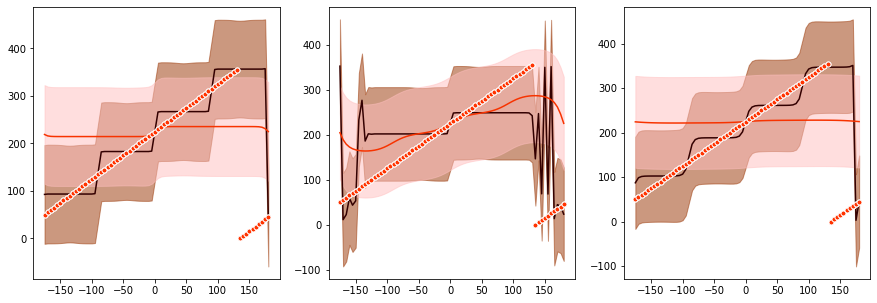

In [25]:
# plot
plt.figure(figsize=(15,5))
plot_mean(
    output["data_mean"],
    output["data_std"],
    output["prediction_mean"],
    output["prediction_std"],
    output["conditions"],
    prior_mode=PRIOR_MODE,
    centering=CENTERING,
)

## Inspect the model's trained parameters

### Measure built-in cardinal prior strength

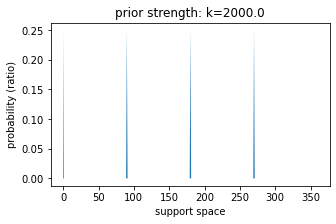

In [43]:
# set support space and get cardinal prior 
# strength
k_c = model.best_fit_p.tolist()[5]
support_space = np.arange(0,360,1)

# plot prior
plt.figure(figsize=(5,3))
plot_von_mises_mixture(
    support_space=support_space,
    v_u=np.array([0, 90, 180, 270]),
    v_k=k_c
)

# legend
plt.title(f"prior strength: k={k_c}");
plt.ylabel("probability (ratio)");
plt.xlabel("support space");

### Measure learnt priors' strengths

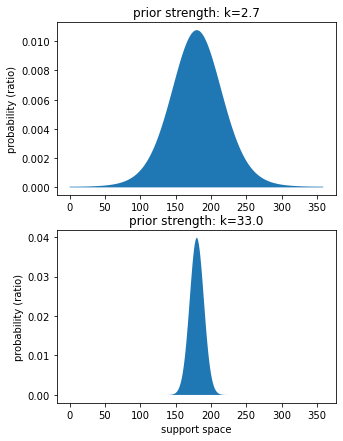

In [27]:
# set support space and get strength
prior_strengths = model.best_fit_p.tolist()[3:5]
support_space = np.arange(0,360,1)
n_strengths = len(prior_strengths)

plt.figure(figsize=(5,7))
for ix, k_p in enumerate(prior_strengths):

    # set panel
    plt.subplot(n_strengths,1,ix+1)

    # plot prior
    plot_von_mises(support_space, k_p)

    # legend
    plt.title(f"prior strength: k={k_p}")
    plt.ylabel("probability (ratio)")
    if ix == len(prior_strengths)-1:
        plt.xlabel("support space")
    

### Measure sensory stimuli strengths (llh)

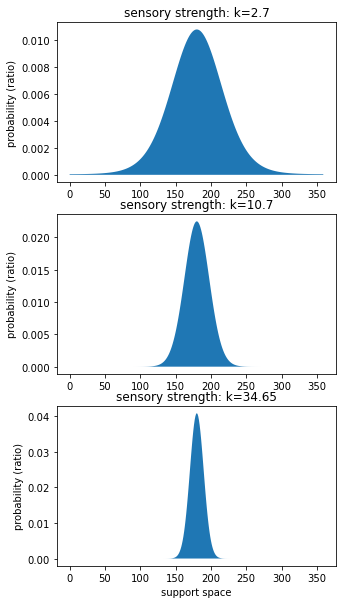

In [28]:
# get strength
sensory_strength = model.best_fit_p.tolist()[0:3]
n_strengths = len(sensory_strength)

plt.figure(figsize=(5,10))
for ix, k_s in enumerate(sensory_strength):

    # set panel
    plt.subplot(n_strengths,1,ix+1)

    # plot prior
    plot_von_mises(support_space, k_s)

    # legend
    plt.title(f"sensory strength: k={k_s}")
    plt.ylabel("probability (ratio)")
    if ix == len(sensory_strength)-1:
        plt.xlabel("support space")

### Measure motor response noise

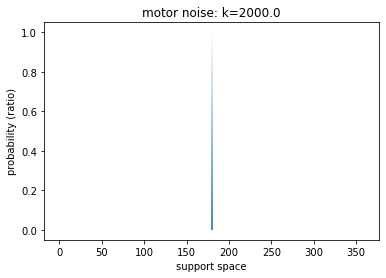

In [29]:
# plot prior
k_m = model.best_fit_p.tolist()[8]
plot_von_mises(support_space, k_m);
plt.title(f"motor noise: k={k_m}");
plt.ylabel("probability (ratio)");
plt.xlabel("support space");

Tutorial complete !